In [1]:
# Ref:https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

sys.path.append('pymodules')
# this class read the raw input and tokenizes comprehensively for use with modeling
import pymodules.read_and_tokenize as contacts_utils
from pprint import pprint
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.models import CoherenceModel

/Users/bmukund/miniconda3/lib/python3.8/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.3.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [2]:
filename = "data/Master-data_Q42021.xlsx"
prep_comments, df = contacts_utils.read_file(filename)


Read sheet 'Scrubbed_data' ...
Columns dropped: ['OVERALL_RATING', 'COMFORT_RATING', 'VISION_RATING', 'VALUE_FOR_MONEY', 'PROS', 'CONS', 'ORIGINAL_SOURCE', 'REPLY_FROM_ACCUVUE', 'PRODUCT_LINK', 'WEBSITE']
 Drop the Author column and replace it with gender of author ...
Consolidate all the comments into one column called COMMENT
Make ratings into integers
Tokenize data based on regex found from experimentation and common usage ...
Comments before tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments after tokenization at index[0]:
 Acucue 2 Contact Lenses I have used these lenses for a long time and I have to say that the service from Lens.com is great and the lenses work great for my needs!  I highly recommend them!
Comments at index[0] before basic cleaning:
 Acucue 2 Contact Lenses I have used these lenses for a lon

In [3]:
for i in range(len(prep_comments.tokens)):
    prep_comments.tokens[i] = prep_comments.tokens[i] + prep_comments.bigrams[i]

In [4]:
# apply lemmatization to all documents (takes a very long time so we will avoid it for now)
prep_comments.lemmatize()

In [5]:
test_index = 0
print(f"Comments at index[{test_index}] after addition of bigrams:\n {prep_comments.tokens[test_index]}")
print(f"Comments at index[{-1}] after addition of bigrams:\n {prep_comments.tokens[-1]}")

Comments at index[0] after addition of bigrams:
 ['contact', 'used', 'time', 'service', 'com', 'great', 'work', 'great', 'needs', 'highly', 'recommend', 'contact-used', 'used-time', 'time-service', 'service-com', 'com-great', 'great-work', 'work-great', 'great-needs', 'needs-highly', 'highly-recommend']
Comments at index[-1] after addition of bigrams:
 ['buy', 'order', 'came', 'fast', 'without', 'issues', 'candy', 'nice', 'touch', 'buy-order', 'order-came', 'came-fast', 'fast-without', 'without-issues', 'issues-candy', 'candy-nice', 'nice-touch']


In [6]:
# Create Dictionary
id2word = corpora.Dictionary(prep_comments.tokens)

In [7]:
# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in prep_comments.tokens]

### How many topics to consider ?
Look at the coherence score and choose one with highest score

In [8]:
num_topics = [5, 4, 3, 2]
lda_models = {}
coherence_scores = dict()
for nt in num_topics:
    # Build LDA model
    lda_models[nt] = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=nt,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=10,
                                            passes=10,
                                            alpha='symmetric',
                                            iterations=100,
                                            per_word_topics=True)

    pprint(lda_models[nt].print_topics())
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_models[nt], texts=prep_comments.tokens, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print(f"\n ====> Coherence Score for number of topics {nt}: {coherence_lda}")
    coherence_scores[nt] = coherence_lda

[(0,
  '0.081*"great" + 0.046*"good" + 0.038*"price" + 0.037*"service" + '
  '0.025*"best" + 0.020*"quality" + 0.013*"excellent" + 0.011*"time" + '
  '0.010*"great-service" + 0.010*"great-price"'),
 (1,
  '0.031*"contact" + 0.027*"day" + 0.027*"wear" + 0.021*"eyes" + 0.018*"love" '
  '+ 0.016*"wearing" + 0.015*"used" + 0.013*"worn" + 0.012*"can" + '
  '0.011*"work"'),
 (2,
  '0.074*"contacts" + 0.031*"fast" + 0.019*"always" + 0.018*"delivery" + '
  '0.013*"shipping" + 0.012*"quick" + 0.010*"ordering" + 0.010*"prescription" '
  '+ 0.009*"fast-shipping" + 0.009*"issues"'),
 (3,
  '0.045*"product" + 0.035*"years" + 0.034*"easy" + 0.019*"eyes" + '
  '0.017*"will" + 0.017*"dry" + 0.017*"using" + 0.014*"use" + 0.013*"fit" + '
  '0.012*"buy"'),
 (4,
  '0.113*"comfortable" + 0.036*"order" + 0.019*"eye" + '
  '0.014*"comfortable-wear" + 0.013*"really" + 0.013*"comfort" + 0.011*"came" '
  '+ 0.009*"perfect" + 0.008*"found" + 0.006*"toric"')]

 ====> Coherence Score for number of topics 5: 0.4290

### Do we use the number of topics for which the coherence score is the highest ?
* Upon experimentation, we see that the number of document topics is 3.

In [9]:
best_index = 3# max(coherence_scores, key=lambda key: coherence_scores[key])
print(f"Best index for which the coherence is the highest is: {best_index}, coherence score:{coherence_scores[best_index]}")
lda_model = lda_models[best_index]

Best index for which the coherence is the highest is: 3, coherence score:0.5151735953191129


In [10]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=None):
    # Init output
    records_list = []
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                records_list.append([int(topic_num), round(prop_topic,4), topic_keywords])
            else:
                break

    out_df = pd.DataFrame.from_records(records_list)
    out_df.columns = ['Dominant_Topic', 'Pct_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    out_df = pd.concat([out_df, contents], axis=1)
    return(out_df)


df_with_topic_r = format_topics_sentences(ldamodel=lda_model,
                                                  corpus=corpus,
                                                  texts=prep_comments.tokens)

# Format the output above with these columns and new data added and label the columns appropriately
df_with_topic = df_with_topic_r.reset_index()
df_with_topic.columns = ['Document_No', 'Dominant_Topic', 'Pct_Contrib_to_Topic', 'Keywords', 'Text']
df_with_topic.head(10)

,Document_No,Dominant_Topic,Pct_Contrib_to_Topic,Keywords,Text
0,0,1,0.5588,"great, good, product, price, service, easy, or...","[contact, used, time, service, com, great, wor..."
1,1,2,0.9048,"will, contacts, days, prescription, came, much...","[clear, vision, tends, cloud, clear-vision, vi..."
2,2,0,0.6283,"comfortable, eyes, contacts, years, day, wear,...","[comfort, hard, handle, flimsy, comfortable, e..."
3,3,1,0.6036,"great, good, product, price, service, easy, or...","[easy, use, using, product, years, reliable, e..."
4,4,1,0.7503,"great, good, product, price, service, easy, or...","[excellent, excellent, got, promised, discount..."
5,5,1,0.8169,"great, good, product, price, service, easy, or...","[fast, service, can, always, rely, contacts, c..."
6,6,0,0.7162,"comfortable, eyes, contacts, years, day, wear,...","[great, brand, best, brand, use, contact, grea..."
7,7,1,0.6035,"great, good, product, price, service, easy, or...","[great, experience, convenient, comfortable, a..."
8,8,1,0.5492,"great, good, product, price, service, easy, or...","[service, really, quick, delivery, correct, re..."
9,9,0,0.3333,"comfortable, eyes, contacts, years, day, wear,...",[]


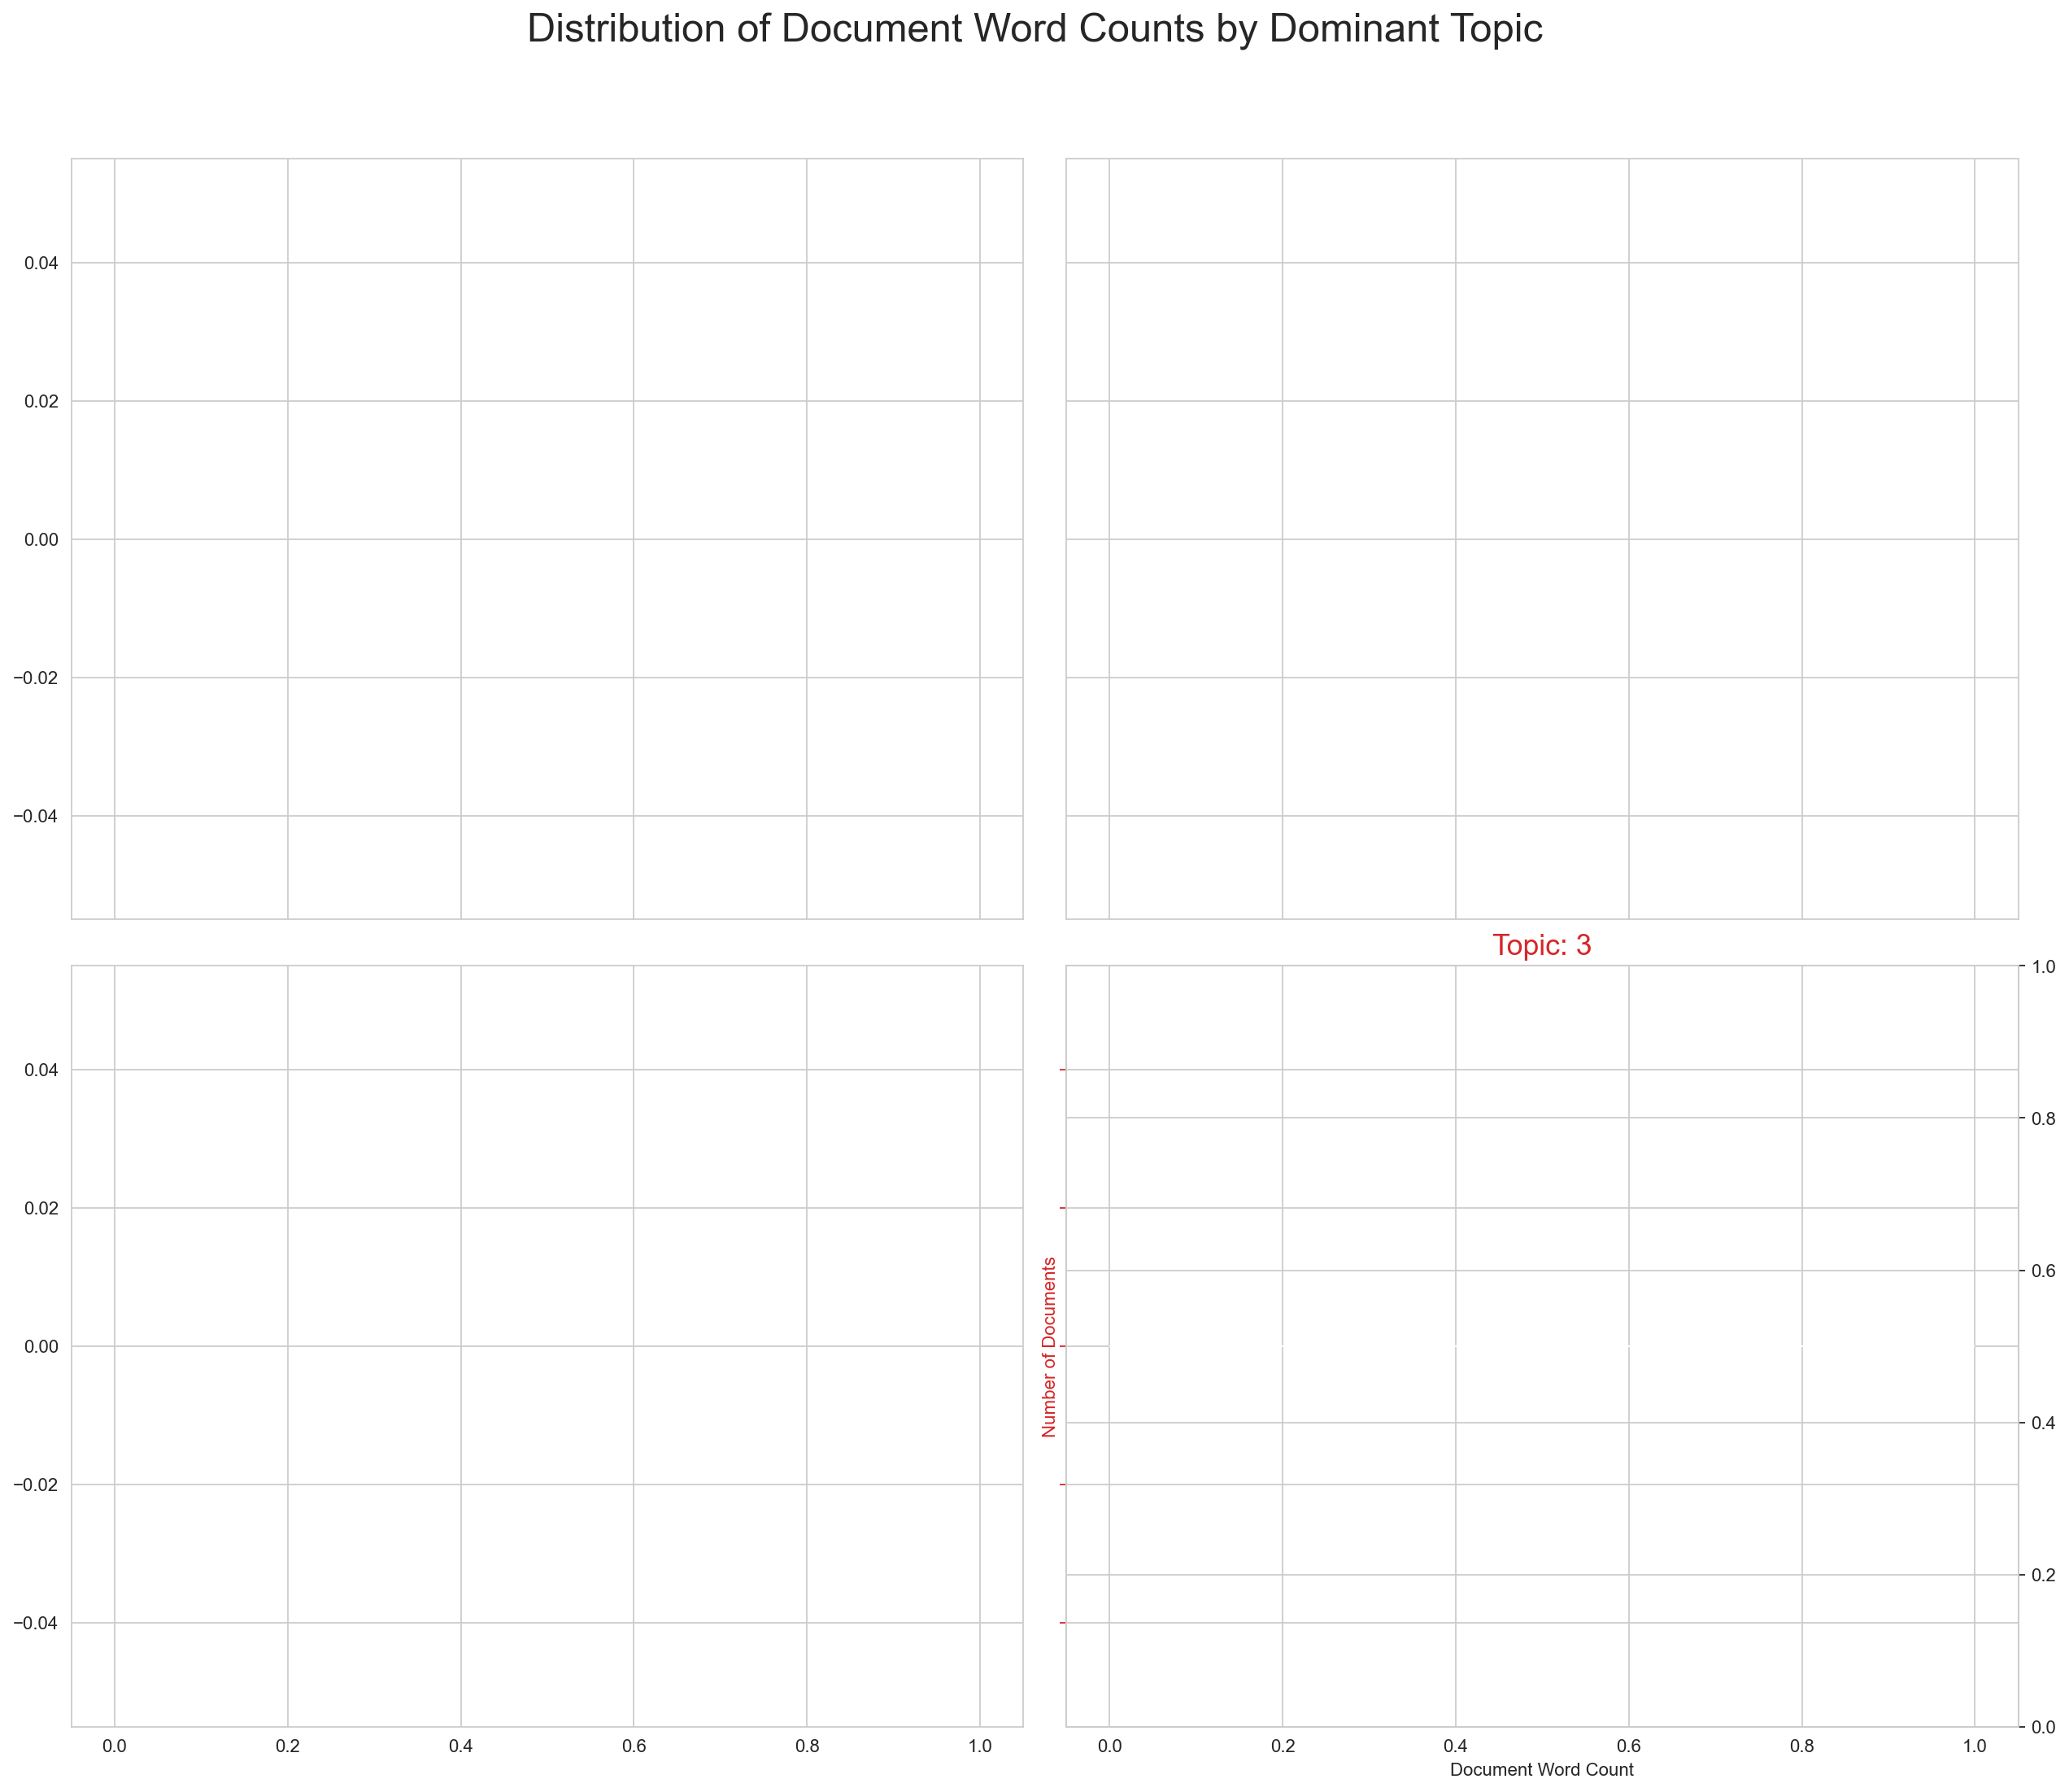

In [11]:
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex='all', sharey='all')

for i, ax in enumerate(axes.flatten()):
    df_with_topic_sub = df_with_topic.loc[df_with_topic.Dominant_Topic == i, :]
    doc_lengths = np.array([len(d) for d in df_with_topic_sub.Text])
    plt_data = doc_lengths
    ax.hist(plt_data, bins = 50, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    # note the twin x
    sns.kdeplot(plt_data, color="black", shade=False, ax=ax.twinx())
    #ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_xlabel('Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
#plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

/var/folders/bk/93tv9tk147s32tbjbfrfb79w0000gn/T/ipykernel_44605/551647997.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/bk/93tv9tk147s32tbjbfrfb79w0000gn/T/ipykernel_44605/551647997.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/bk/93tv9tk147s32tbjbfrfb79w0000gn/T/ipykernel_44605/551647997.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


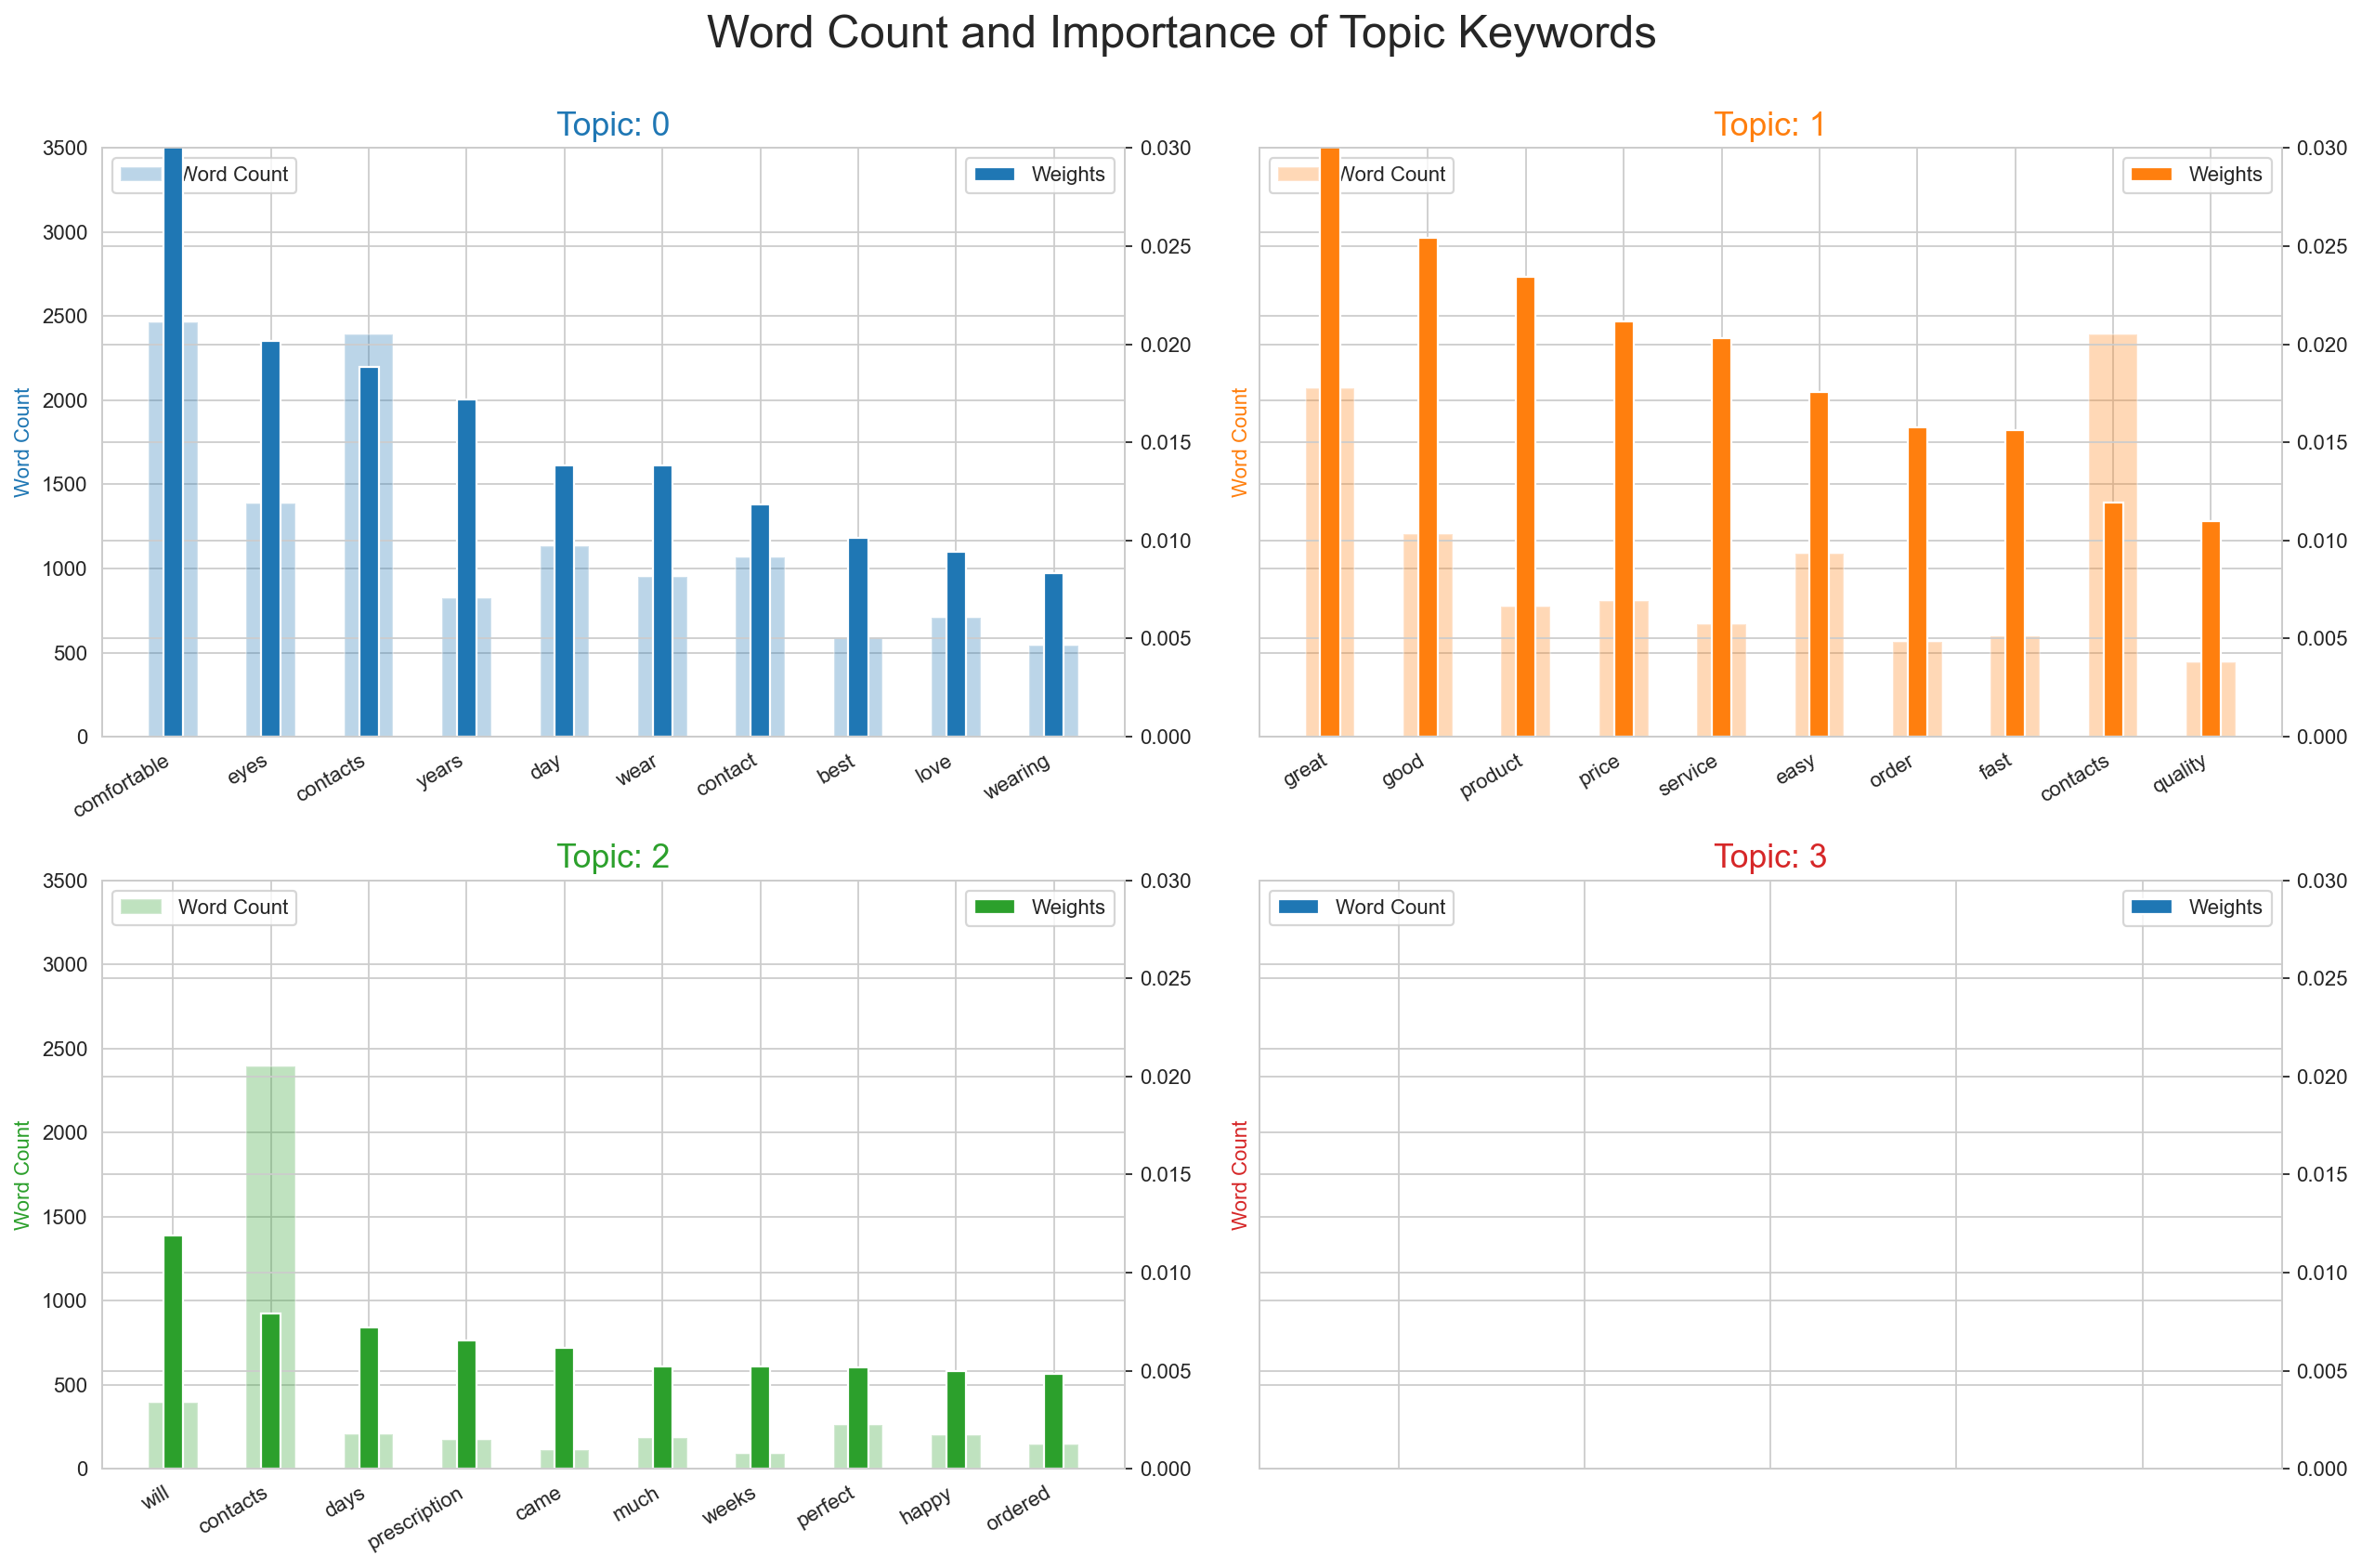

In [12]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in prep_comments.tokens for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey='all', dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
plt.show()

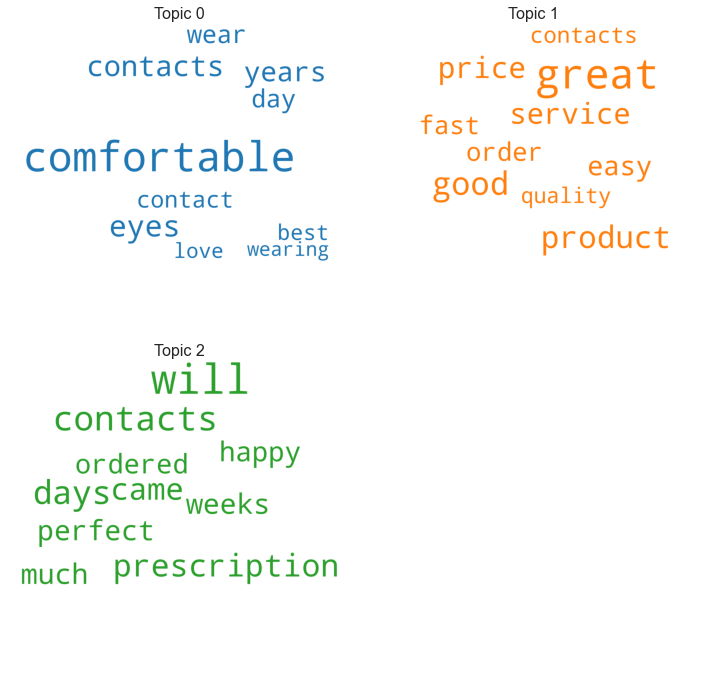

In [13]:
# 1. Wordcloud of Top N words in each topic
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=prep_comments.stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex='all', sharey='all')

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    try:
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    except IndexError:
        pass

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### What are the most discussed topics in the documents?

In [14]:
### What are the most discussed topics in the documents?
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return (dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False)
                   for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

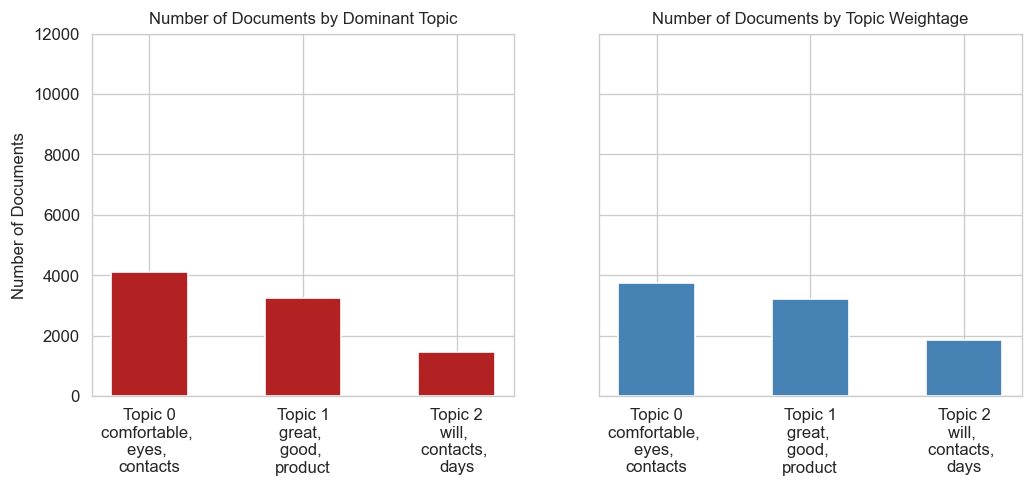

In [15]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey='all')

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 12000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()


In [16]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

/Users/bmukund/miniconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.192465 -0.125365       1        1  45.602320
1     -0.233523 -0.069127       2        1  29.246569
2      0.041058  0.194492       3        1  25.151111, topic_info=             Term         Freq        Total Category  logprob  loglift
29    comfortable  2665.000000  2665.000000  Default  30.0000  30.0000
4           great  1700.000000  1700.000000  Default  29.0000  29.0000
202          good   955.000000   955.000000  Default  28.0000  28.0000
42        product   881.000000   881.000000  Default  27.0000  27.0000
205         price   796.000000   796.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
2053     purchase    91.968969   120.237109   Topic3  -5.8616   1.1123
25         vision   123.628138   262.314344   Topic3  -5.5657   0.6280
71       contacts   255.937123  1807.161425   Topic3  -4.8381  -0.5743
690          week   107.646854   197.291776   Topic3  -5.7042   0.7744
32            eye   112.668647   410.895995   Topic3  -5.6586   0.0864

[153 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
88        1  0.022012  affordable
88        2  0.975846  affordable
65        1  0.441736      always
65        2  0.557601      always
2561      2  0.013803      arrive
...     ...       ...         ...
3301      1  0.007622       worst
3301      3  0.990851       worst
721       3  0.994130        year
49        1  0.999915       years
878       3  0.983069         yet

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

### Coherence measure: How good is our autmatic topic modeling ?
Ref: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
Paper: Exploring the Space of Topic Coherence Measures, Michael Röder, Andreas Both, Alexander Hinneburg

The higher the score, the better the coherence ...

In [17]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=prep_comments.tokens, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5151735953191129
